In [62]:
#@formatter:off
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve,\
    roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set_theme(style='whitegrid')
#@formatter:on

## Data fetching

In [3]:
mnist = fetch_openml('mnist_784')
# mnist

In [4]:
X, y = np.array(mnist['data']), np.array(mnist['target'])
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


0


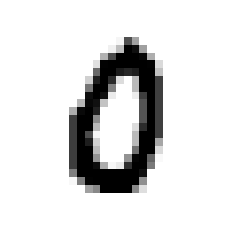

In [5]:
rnum = np.random.randint(0, X.shape[0])
some_digit = X[rnum]
sd_image = some_digit.reshape(28, 28)
plt.imshow(sd_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
print(y[rnum])

## Set partition

In [6]:
shuffle_index = np.random.permutation(60000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
sgd_clf = SGDClassifier(random_state=228)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=228)

SGDClassifier(random_state=228)

In [10]:
sgd_clf.predict([some_digit])

array([False])

In [8]:
skfolds = StratifiedKFold(n_splits=3, random_state=228, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9577
0.9671
0.9501


In [11]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96695, 0.9645 , 0.949  ])

In [15]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90825, 0.9089 , 0.9118 ])

## Metrics

In [19]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53158,  1421],
       [  970,  4451]])

In [25]:
print(precision_score(y_train_5, y_train_pred))  # TP / (TP + FP)
print(recall_score(y_train_5, y_train_pred))  # TP / (TP + FN)
print(f1_score(y_train_5, y_train_pred))  # 2 / (1 / prec + 1 / rec)

0.7580040871934605
0.8210662239439218
0.7882759231382273


In [27]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_scores)

[-4056.03280748]
[-10456.66658159 -12854.97646455 -17008.55715089 ... -55597.93294237
 -13311.01250093  -4152.4811576 ]


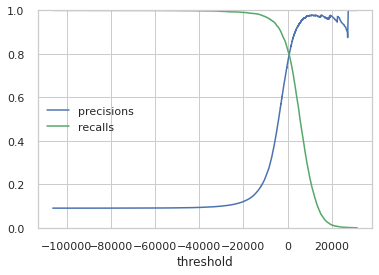

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0, 0.5, 'precisions')

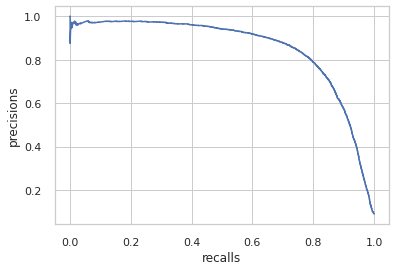

In [50]:
plt.plot(recalls, precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')

In [56]:
y_train_pred_90 = (y_scores > 3500)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.90216271884655
0.6463752075262866


0.9651632274804994

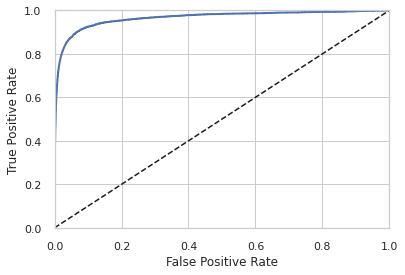

In [61]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train_5, y_scores)

In [63]:
forest_clf = RandomForestClassifier(random_state=228)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
print(y_probas_forest)
print(y_scores_forest)

[[0.99 0.01]
 [0.94 0.06]
 [0.99 0.01]
 ...
 [0.99 0.01]
 [0.99 0.01]
 [1.   0.  ]]
[0.01 0.06 0.01 ... 0.01 0.01 0.  ]


0.9983722529859533


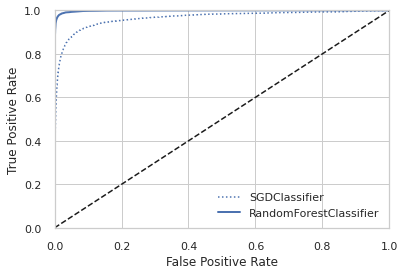

In [70]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label='SGDClassifier')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForestClassifier')
plt.legend()
print(roc_auc_score(y_train_5, y_scores_forest))